In [37]:
# Read from Datasets/ECG5000/ECG5000_TEST.txt

import numpy as np
import matplotlib.pyplot as plt

# Read from Datasets/ECGFiveDays/ECGFiveDays_TEST.txt, and get the first column as the labels
true_labels = np.genfromtxt('Datasets/ECG5000/ECG5000.txt', delimiter=' ', usecols=0)

# Read from Datasets/ECGFiveDays/ECGFiveDays_TEST.txt
data = np.genfromtxt('Datasets/ECG5000/ECG5000.txt', delimiter='  ', usecols=range(1,141))

(5000, 140)


In [40]:
# Remove the data with label 3 and 5
data = data[true_labels != 3]
true_labels = true_labels[true_labels != 3]
data = data[true_labels != 5]
true_labels = true_labels[true_labels != 5]

# Print size of data and labels
print("Size of data: ", data.shape)
print("Size of labels: ", true_labels.shape)

Size of data:  (4880, 140)
Size of labels:  (4880,)


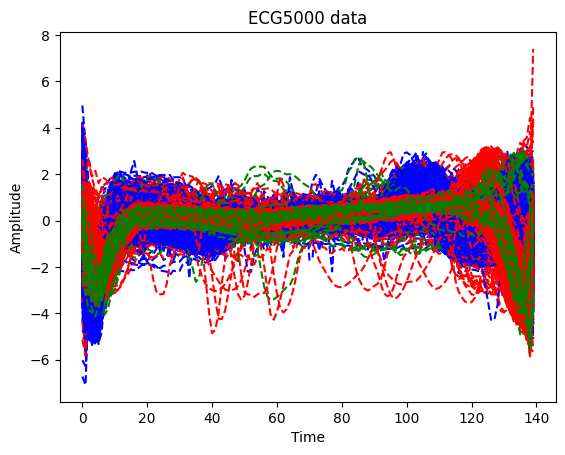

In [42]:
# Plot the data
for i in range(len(data)):
    if true_labels[i] == 1:
        plt.plot(data[i], linestyle='--', color='b')
    elif true_labels[i] == 2:
        plt.plot(data[i], linestyle='--', color='r')
    else:
        plt.plot(data[i], linestyle='--', color='g')
plt.title('ECG5000 data')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.show()


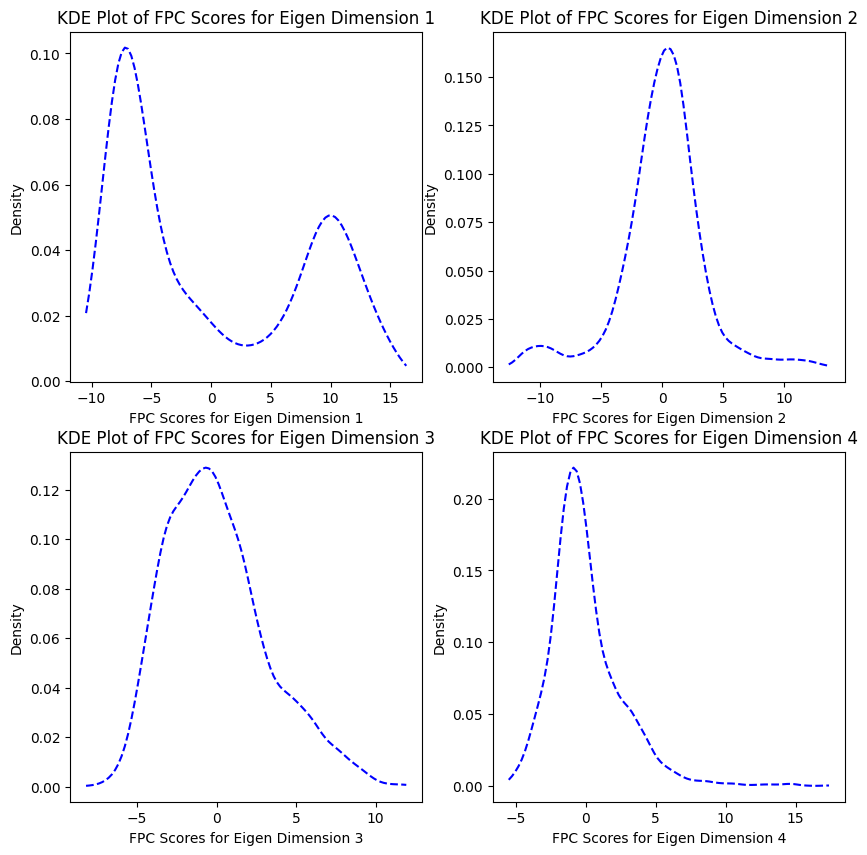

In [43]:
import scipy
from scipy import spatial, interpolate
from ensemble_clustering import functional_data_decomposition, functional_data_clustering
from fda_results import percentage_variation_ami_ari, plot_percentage_variation_ami_ari

data_smooth, mean, principal_componenets, eigen_functions = functional_data_decomposition (data, 10, 250)

# For loop to plot a 2x2 set of scatter plots for the kernel density plots of the first four principal components
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i in range(4):
    # Kernel density plot for principal components[i], as a scatter plot
    # Determine the desnity of principal components[i]
    kde = scipy.stats.gaussian_kde(principal_componenets[:,i])
    # Create a grid of points
    x_grid = np.linspace(min(principal_componenets[:,i]), max(principal_componenets[:,i]), 100)
    # Evaluate the density on the grid
    density = kde(x_grid)
    # Plot the density
    ax[i//2, i%2].plot(x_grid, density, color='b', linestyle='--')
    ax[i//2, i%2].set_title('KDE Plot of FPC Scores for Eigen Dimension ' + str(i+1))
    ax[i//2, i%2].set_xlabel('FPC Scores for Eigen Dimension ' + str(i+1))
    ax[i//2, i%2].set_ylabel('Density')
plt.show()

Percentage of variation explained by each eigen dimensions:  [0.58878646 0.10749058 0.09898293 0.06232414 0.0459044  0.03002976
 0.02720276 0.01610058 0.01273073 0.01044767]


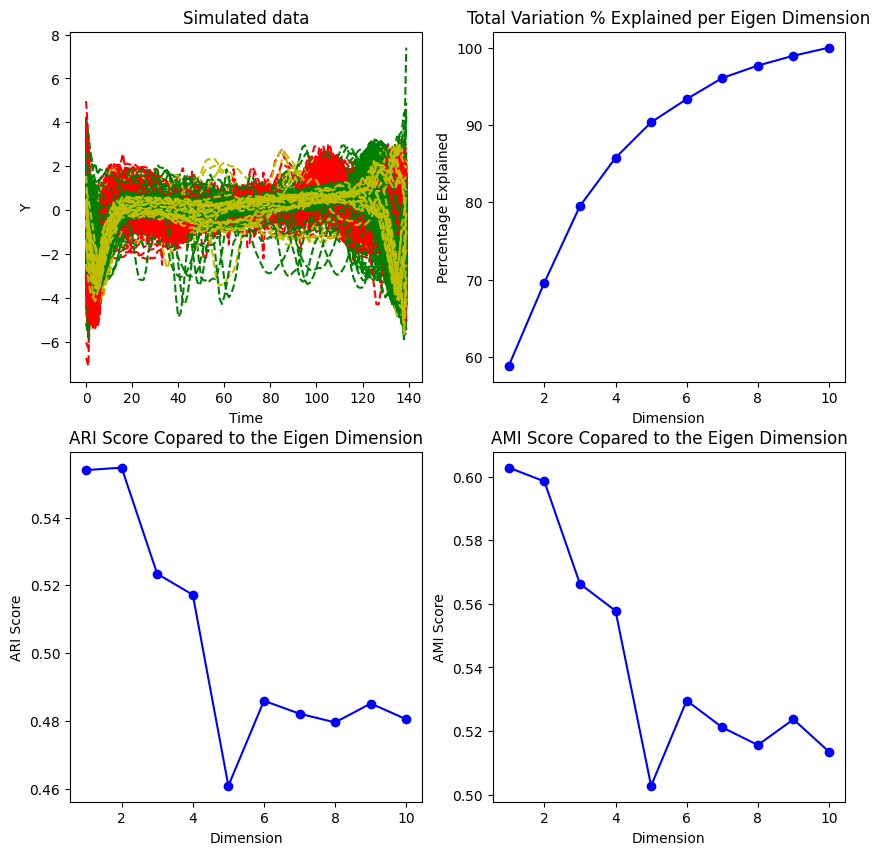

In [44]:
variance, ami, ari, v_range = percentage_variation_ami_ari(10, data, 150, true_labels, 3)
plot_percentage_variation_ami_ari(variance, ami, ari, v_range, true_labels, data)

In [45]:
# Determine the Eigen Dimension that explains 95% of the variance
for i in range(len(variance)):
    if sum(variance[:i]) >= 0.95:
        print('The Eigen Dimension that explains 95% of the variance is ' + str(i-1))
        V = i -1
        break

The Eigen Dimension that explains 95% of the variance is 7


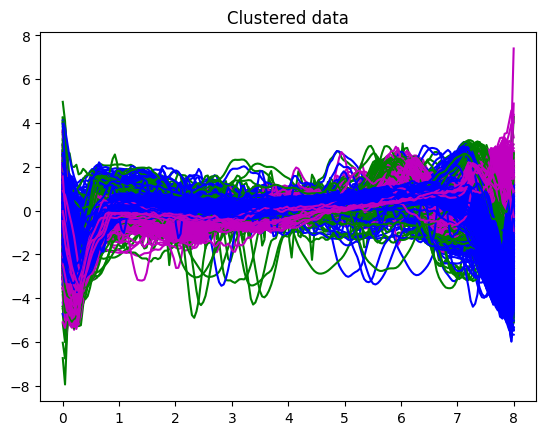

AMI score: 0.553724
ARI score: 0.602013


In [52]:
# Get data from the first function
data_smooth, mean, principal_componenets, eigen_functions = functional_data_decomposition (data, 1, 200)

# Get data from the second function
membership_matrices, labels = functional_data_clustering (principal_componenets, 3)

# Plot the curves with their labels
t = np.expand_dims(np.linspace(0, 8, len(data_smooth[0])), 1)
for i in range(len(data_smooth)):
    if labels[i] == 0:
        plt.plot(t, data_smooth[i], '-m')
    elif labels[i] == 1:
        plt.plot(t, data_smooth[i], '-b')
    elif labels[i] == 2:
        plt.plot(t, data_smooth[i], '-g')
    elif labels[i] == 3:
        plt.plot(t, data_smooth[i], '-c')
    elif labels[i] == 4:
        plt.plot(t, data_smooth[i], '-y')
    elif labels[i] == 5:
        plt.plot(t, data_smooth[i], '-k')
    else:
        plt.plot(t, data_smooth[i], '-r')
plt.title('Clustered data')
plt.show()

from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

print("AMI score: %f" % adjusted_mutual_info_score(true_labels, labels))
print("ARI score: %f" % adjusted_rand_score(true_labels, labels))

In [47]:
from FDApy.clustering.fcubt import Node, FCUBT
from FDApy.representation.functional_data import DenseFunctionalData

# Ignore the warning
import warnings
warnings.filterwarnings("ignore")

# Make t a dict
t = np.expand_dims(np.linspace(0, 20, len(data[0])), 1)
t = {'input_dim_0': t}
# Change t from (100, 1) to (100,)
t = {k: v.squeeze() for k, v in t.items()}

fcubt_data = DenseFunctionalData(t, data)
# Build the tree
root_node = Node(fcubt_data, is_root=True)
fcubt = FCUBT(root_node=root_node)

# Growing
fcubt.grow(n_components=0.95, min_size=10)

# Joining
fcubt.join(n_components=0.95)

# Get the ARI
print("ARI score for FCUBT: %f" % adjusted_rand_score(true_labels, fcubt.labels_join))
# Get the AMI
print("AMI score for FCUBT: %f" % adjusted_mutual_info_score(true_labels, fcubt.labels_join))

KeyboardInterrupt: 

Failed to Converge

In [49]:
# Store the data in DataStore.csv
np.savetxt('Data/DataStore.csv', data, delimiter=',')
np.savetxt('Data/LabelStore.csv', true_labels, delimiter=',')

In [51]:
# To simulate funHDDC, run run the R file funHDDC.R

# Read Labels from PredictedLabels.csv, ignoring the header and the first column
predicted_labels = np.genfromtxt('Data/PredictedLabelsStore.csv', delimiter=',', skip_header=1, usecols=1)
print("ARI score for funHDDC: %f" % adjusted_rand_score(true_labels, predicted_labels))
print("AMI score for funHDDC: %f" % adjusted_mutual_info_score(true_labels, predicted_labels))

ARI score for funHDDC: 0.626620
AMI score for funHDDC: 0.591252


In [54]:
# To simulate funFEM, run run the R file funFEM.R

# Read labels from PredictedLabels.csv, ignoring the header and the first column and getting the first four columns
predicted_labels = np.genfromtxt('Data/PredictedLabelsStore.csv', delimiter=',', skip_header=1, usecols=range(1, 4))
#   Format the labels
labels = np.zeros(len(predicted_labels))
for i in range(len(predicted_labels)):
    labels[i] = np.argmax(predicted_labels[i])
print("ARI score for funFEM: %f" % adjusted_rand_score(true_labels, labels))
print("AMI score for funFEM: %f" % adjusted_mutual_info_score(true_labels, labels))


ARI score for funFEM: 0.269485
AMI score for funFEM: 0.271473
